# Conditional Neural Processes (CNP).
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os
from resum.utilities import plotting_utils_cnp as plotting
from resum.utilities import utilities as utils
from resum.conditional_neural_process import DataGeneration
from resum.conditional_neural_process import DeterministicModel
import yaml

In [2]:
with open("legend-neutron-moderator/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

TRAINING_EPOCHS = int(config_file["cnp_settings"]["training_epochs"]) # Total number of training points: training_iterations * batch_size * max_content_points
PLOT_AFTER = int(config_file["cnp_settings"]["plot_after"])
torch.manual_seed(0)
BATCH_SIZE = config_file["cnp_settings"]["batch_size"]

version_cnp= config_file["cnp_settings"]["version"]
version_lf= config_file["simulation_settings"]["version_lf"]

path_out = config_file["path_settings"]["path_out"]
f_out = config_file["path_settings"]["f_out"]


In [3]:
x_size, y_size = utils.get_feature_and_label_size(config_file)

Data Augmentation in Progress: Applying transformations...


100%|██████████| 1/1 [00:00<00:00, 78.87it/s]


2025-03-20 22:58:28 Iteration: 0/0, train loss: 1.5773 (vs BCE 0.6924)
2025-03-20 22:58:28, Iteration: 0, test loss: 1.6183 (vs BCE 0.6746)


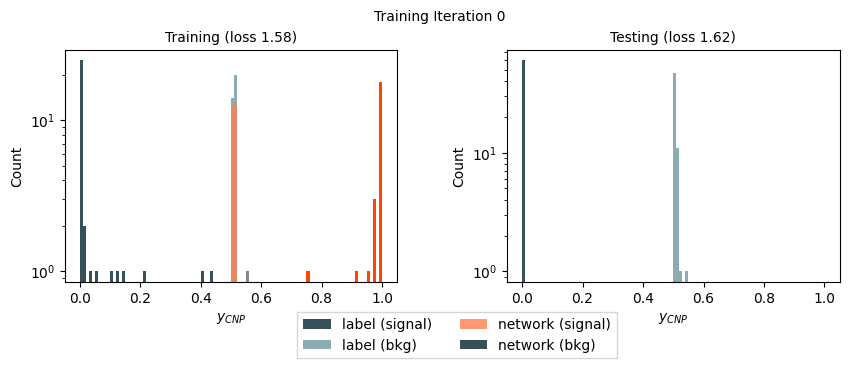

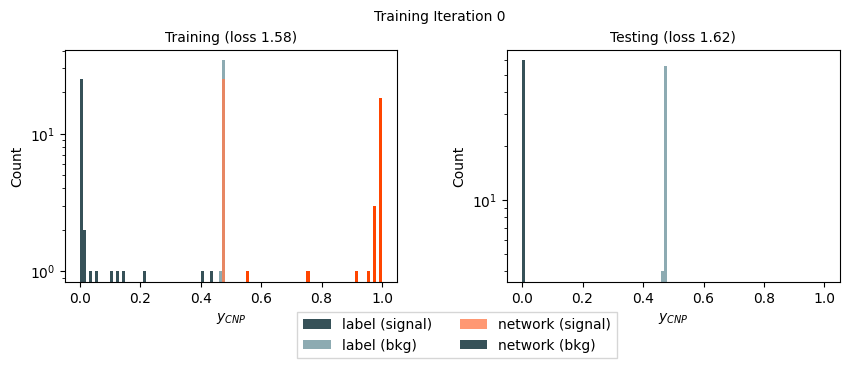

2025-03-20 22:58:31 Iteration: 0/50, train loss: 1.5666 (vs BCE 0.6878)
2025-03-20 22:58:31, Iteration: 50, test loss: 1.6082 (vs BCE 0.6654)


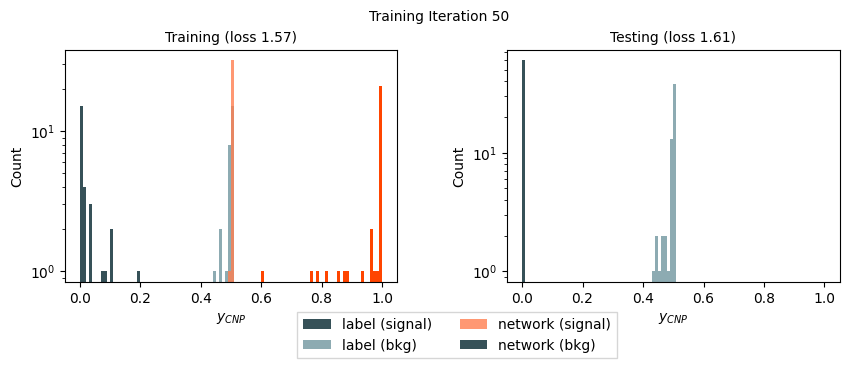

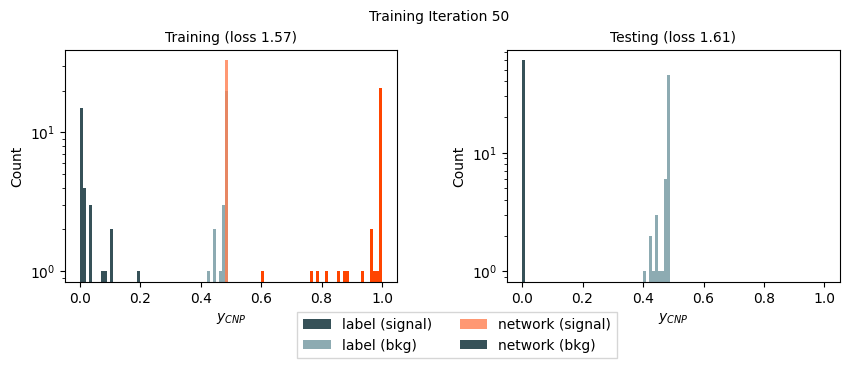

2025-03-20 22:58:33 Iteration: 0/100, train loss: 1.5287 (vs BCE 0.6641)
2025-03-20 22:58:33, Iteration: 100, test loss: 1.6007 (vs BCE 0.6578)


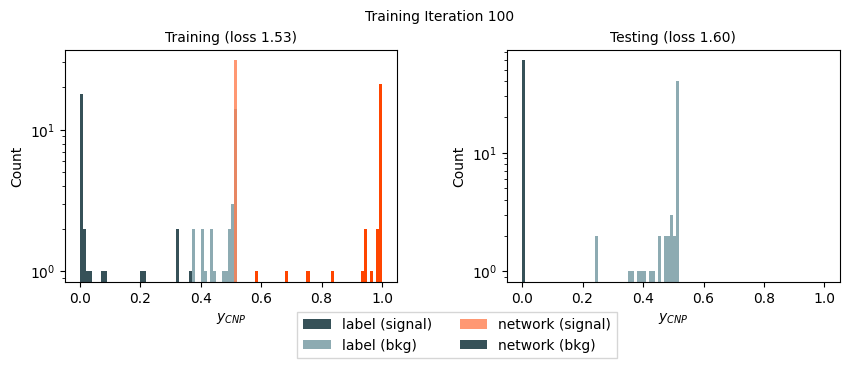

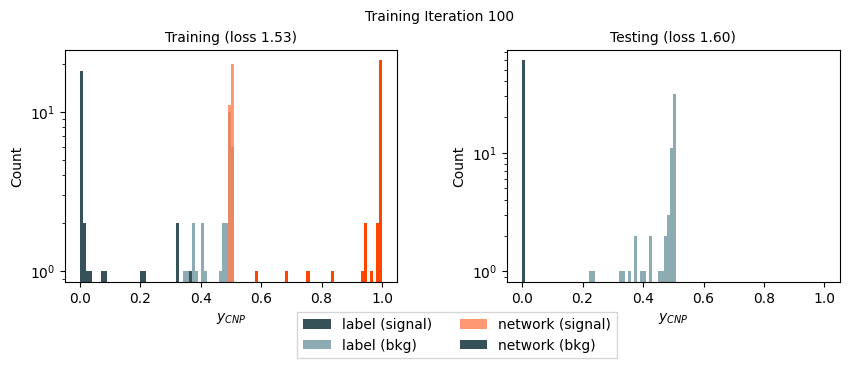

2025-03-20 22:58:35 Iteration: 0/150, train loss: 1.4948 (vs BCE 0.6186)
2025-03-20 22:58:35, Iteration: 150, test loss: 1.5605 (vs BCE 0.6031)


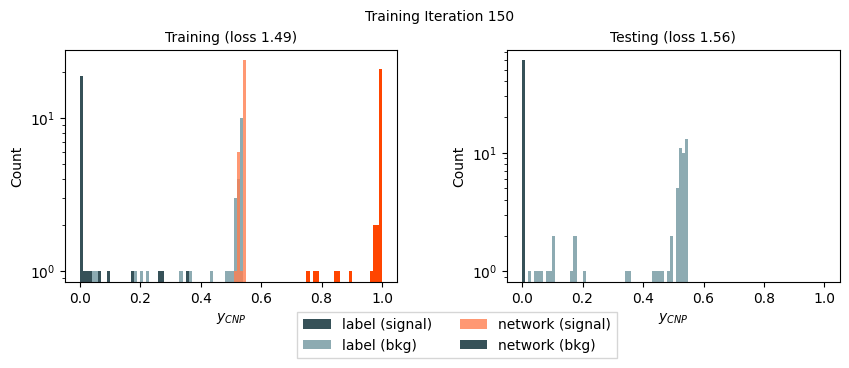

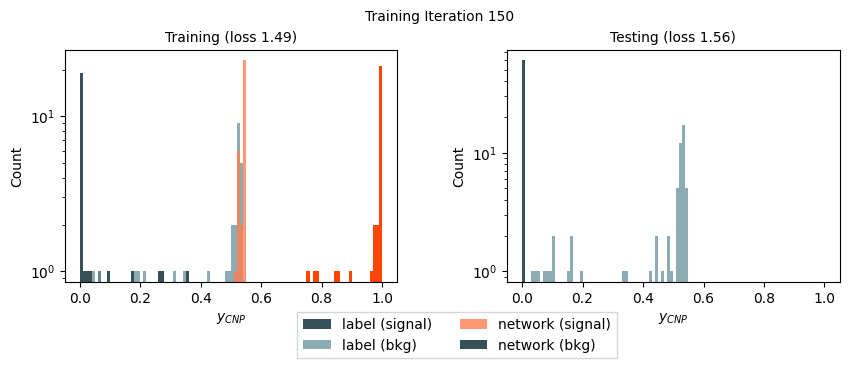

Finished full dataset pass. Starting new epoch!  166


In [11]:

d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size*2
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = DeterministicModel(encoder_sizes, decoder_sizes)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# 

bce = nn.BCELoss()
iter_testing = 0

# create a PdfPages object
test_idx=0
for it_epoch in range(TRAINING_EPOCHS):
    
    USE_DATA_AUGMENTATION = config_file["cnp_settings"]["use_data_augmentation"]
    # load data:
    dataset_train = DataGeneration(mode = "training", config_file=config_file, path_to_files=config_file["path_settings"]["path_to_training_files"], use_data_augmentation=USE_DATA_AUGMENTATION, batch_size=BATCH_SIZE)
    dataset_train.set_loader()
    dataloader_train = dataset_train.dataloader

    dataset_test = DataGeneration(mode = "training", config_file=config_file, path_to_files=config_file["path_settings"]["path_to_training_files"], use_data_augmentation=False, batch_size=BATCH_SIZE)
    dataset_test.set_loader()
    dataloader_test = dataset_test.dataloader
    data_iter = iter(dataloader_test)
    it_batch = 0

    for b, batch in enumerate(dataloader_train):
        batch_formated=dataset_train.format_batch_for_cnp(batch,config_file["cnp_settings"]["context_is_subset"] )
        # Get the predicted mean and variance at the target points for the testing set
        log_prob, mu, _ = model(batch_formated.query, batch_formated.target_y)

        # Define the loss
        loss = -log_prob.mean()
        loss.backward()

        # Perform gradient descent to update parameters
        optimizer.step()
    
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()
        
        #if max(mu[0].detach().numpy()) <= 1 and min(mu[0].detach().numpy()) >= 0:
        loss_bce = bce(mu, batch_formated.target_y)
        #else:
        #    loss_bce = -1.
        
        mu=mu[0].detach().numpy()
        
        if it_batch % 50 == 0:
            print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),it_epoch, it_batch,loss, loss_bce))
            batch_testing = next(data_iter)
            batch_formated_test=dataset_train.format_batch_for_cnp(batch_testing,config_file["cnp_settings"]["context_is_subset"] )
            
            log_prob_testing, mu_testing, _ = model(batch_formated_test.query, batch_formated_test.target_y)
            loss_testing = -log_prob_testing.mean()
            test_idx+=1

            #if max(mu_testing[0].detach().numpy()) <= 1 and min(mu_testing[0].detach().numpy()) >= 0:
            loss_bce_testing = bce(mu_testing,  batch_formated_test.target_y)
            #else:
            #    loss_bce_testing = -1.

            mu_testing=mu_testing[0].detach().numpy()
            print("{}, Iteration: {}, test loss: {:.4f} (vs BCE {:.4f})".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it_batch, loss_testing, loss_bce_testing))
            if y_size ==1:
                fig = plotting.plot(mu, batch_formated_test.target_y[0].detach().numpy(), f'{loss:.2f}', mu_testing, batch_formated_test.target_y[0].detach().numpy(), f'{loss_testing:.2f}', it_batch)
            else:
                for k in range(y_size):
                    fig = plotting.plot(mu[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_testing[:,k], batch_formated_test.target_y[0].detach().numpy()[:,k], f'{loss_testing:.2f}', it_batch)

        it_batch+=1

torch.save(model.state_dict(), f'{path_out}/{f_out}_model.pth')
